In [1]:
from keras.datasets import mnist
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [9]:
inputs=Input((28,28,1))
x=Conv2D(32,(3,3))(inputs)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(32,(3,3))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(64,(5,5))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(64,(5,5))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(128,(7,7))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(128,(7,7))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Flatten()(x)
x=Dense(2)(x)
out1=PReLU(name="out1")(x)
out2=Dense(10,activation="softmax")(out1)

model=Model(inputs,out2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 26, 26, 32)        21632     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 24, 24, 32)        18432     
__________

In [10]:
lambda_c=1
input_=Input(shape=(1,))
centers=Embedding(10,2)(input_)
intra_loss=Lambda(lambda x:K.sum(K.square(x[0]-x[1][:,0]),1,keepdims=True))([out1,centers])
model_center_loss=Model([inputs,input_],[out2,intra_loss])
model_center_loss.compile(optimizer="sgd",
                          loss=["categorical_crossentropy",lambda y_true,y_pred:y_pred],
                          loss_weights=[1,lambda_c/2.],
                          metrics=["acc"])
model_center_loss.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 26, 26, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 26, 26, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
p_re_lu_7 (PReLU)               (None, 26, 26, 32)   21632       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_8 (

In [11]:
path="mnist.npz"
f = np.load(path)
x_train, y_train = f['x_train'][:30000], f['y_train'][:30000]
x_test, y_test = f['x_test'], f['y_test']
f.close()

x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
x_train/=255.
x_test/=255.
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

y_train_one_hot=to_categorical(y_train)
y_test_one_hot=to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(y_train_one_hot.shape)

(30000, 28, 28, 1)
(30000,)
(30000, 10)


In [15]:
dummy_matrix1=np.zeros((x_train.shape[0],1))
dummy_matrix2=np.zeros((x_test.shape[0],1))

model_center_loss.fit(x=[x_train,y_train],y=[y_train_one_hot,dummy_matrix1],
                     batch_size=512,epochs=100,verbose=1,validation_data=([x_test,y_test],[y_test_one_hot,dummy_matrix2]),
                     callbacks=[EarlyStopping(monitor="val_loss",patience=5)])

Train on 30000 samples, validate on 10000 samples
Epoch 1/100
30000/30000 [==============================] - 5s 156us/step - loss: 1.1225 - dense_4_loss: 1.0143 - lambda_2_loss: 0.2164 - dense_4_acc: 0.7800 - lambda_2_acc: 0.9016 - val_loss: 1.1949 - val_dense_4_loss: 1.0660 - val_lambda_2_loss: 0.2579 - val_dense_4_acc: 0.7562 - val_lambda_2_acc: 0.8699
Epoch 2/100
30000/30000 [==============================] - 5s 154us/step - loss: 1.0914 - dense_4_loss: 0.9930 - lambda_2_loss: 0.1969 - dense_4_acc: 0.8029 - lambda_2_acc: 0.9221 - val_loss: 1.1696 - val_dense_4_loss: 1.0609 - val_lambda_2_loss: 0.2173 - val_dense_4_acc: 0.7760 - val_lambda_2_acc: 0.9139
Epoch 3/100
30000/30000 [==============================] - 5s 153us/step - loss: 1.0909 - dense_4_loss: 0.9854 - lambda_2_loss: 0.2110 - dense_4_acc: 0.7945 - lambda_2_acc: 0.9042 - val_loss: 1.1531 - val_dense_4_loss: 1.0370 - val_lambda_2_loss: 0.2323 - val_dense_4_acc: 0.7802 - val_lambda_2_acc: 0.8886
Epoch 4/100
30000/30000 [====

In [16]:
func=K.function([model.input],[model.get_layer('out1').output])
test_features= func([x_test])[0]
print(test_features.shape)

(10000, 2)


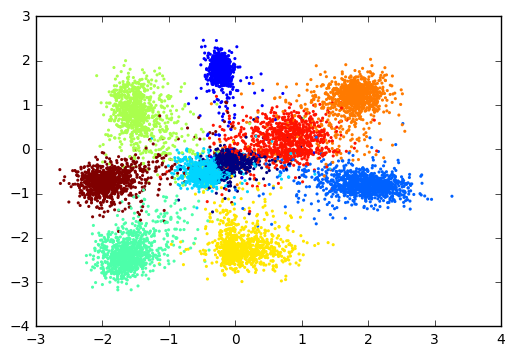

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(test_features[:,0],test_features[:,1],c=y_test,edgecolor="none",s=5)
plt.show()